-  basic block
    -   basic block은 논문 상에서의 block 하나를 의미함
    - 하나의 basic block은 2개의 convolution layer로 구성되어있다.
    - 먼저 conv1 layer를 거치고 batch normalization과 relu를 수행한 뒤, conv2 + batch를 수행한다. 
    - 이후 identity mapping을 이용해서 2개의 convolution을 거친 결과에 input x를 더하고 relu를 씌운다.


- 위의 basic block을 여러 번 연결한다.
    - 실제 논문에서의 구현방식과 동일하다.
    - ImageNet의 아키텍처를 따르며, 입력단의 크기만 CIFAR10에 맞게 바꾼다.

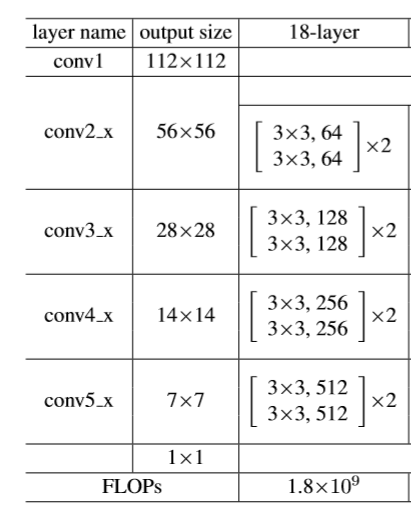

#### ResNet18 모델 정의 및 인스턴스 초기화

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os


# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        # stride는 demension을 바꿀 때 사용한다. (stride=1를 통해 너비와 높이를 절반으로 줄인다.)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)    

        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우. shortcut connection을 위해서 mapping을 수행하도록 한다.
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우 ()= 입력과 출력의 dimension이 다르다)
            self.shortcut = nn.Sequential( # stride를 통해 dimension을 맞추고, 입력값 x가 connection될 수 있도록 만든다.
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

  # 커널을 2개씩 묶어서 shortcut connection까지 적용할 수 있도록 함. 이를 통해 forward pass를 구현
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection   
        out = F.relu(out)
        return out


# ResNet 클래스 정의
# 위의 basic block을 여러 번 연결
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):  # num_blocks: block의 개수를 입력받도록 함
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # dimension을 바꿔줌
        self.bn1 = nn.BatchNorm2d(64)
        # 아래에서 연속적으로 basic block을 연결함
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)    # 2개의 basic block을 수행하므로 총 4개의 layer임
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)  # 맨 처음 conv layer에만 stride를 적용되도록 함. ()= filter의 개수가 바뀔 때만 너비와 높이를 줄임) 2번째 layer에서는 stride=1로 설정됌.
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])  # basic block이 두 번씩 중첩되서 사용되도록 함함

#### 데이터셋(Dataset) 다운로드 및 불러오기

In [ ]:
import torchvision
import torchvision.transforms as transforms

# CFAR10을 사용할 때, 일반적으로 사용되는 테크닉
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),  # data augmentation
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### 환경 설정 및 학습(Training) 함수 정의

In [ ]:
device = 'cuda'

net = ResNet18()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.1
file_name = 'resnet18_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)


def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')


# learning rate를 단계적으로 바꿈
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#### 학습(Training) 진행

* 대략 20번의 epoch 이후에도 85%가량의 test accuracy를 얻을 수 있습니다.

In [ ]:
# for epoch in range(0, 200):
for epoch in range(0, 20):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)


[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.078125
Current benign train loss: 2.342548370361328

Current batch: 100
Current benign train accuracy: 0.234375
Current benign train loss: 1.9885613918304443

Current batch: 200
Current benign train accuracy: 0.3984375
Current benign train loss: 1.592935562133789

Current batch: 300
Current benign train accuracy: 0.375
Current benign train loss: 1.6573998928070068

Total benign train accuarcy: 32.606
Total benign train loss: 728.0853297710419

[ Test epoch: 0 ]

Test accuarcy: 32.37
Test average loss: 0.019251463556289674
Model Saved!

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.4765625
Current benign train loss: 1.467000961303711

Current batch: 100
Current benign train accuracy: 0.4609375
Current benign train loss: 1.41520094871521

Current batch: 200
Current benign train accuracy: 0.4765625
Current benign train loss: 1.416500210762024

Current batch: 300
Current benign train accuracy: 0.